In [84]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [16.0,8.0]

## Define data loading function

In [115]:
def load_data(label_tol,split=.25):
    """
    Loads the data saved from make_dataset() and converts it to tensor
    
    """

    label_tol = str(label_tol)
    data_file= "./data_"+label_tol+".pkl"
    label_file= "./labels_"+label_tol+".pkl"
    
    if not os.path.exists(data_file):
        raise FileNotFoundError("No dataset created with label tolerance: " + label_tol)
    
    # get data
    X = pickle.load(open(data_file, "rb" ))
    y = pickle.load(open(label_file, "rb" ))
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=split)
    
    # transorm into tensors
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)

    # transform test data
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    y_test = torch.from_numpy(y_test).type(torch.LongTensor)
        
    return X_train, X_test, y_train, y_test

## Get accuracy measures

In [96]:
def tf_measures(y_actual, y_hat):
    """
    returns:
        TP: true positve 
        FP: false positive 
        TN: true negative 
        FN: False negative 
    """
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)

In [97]:
def get_all_measurments(measures):
    """
        Gets all measures of any kinda of accuracy
    """
    TP, FP, TN, FN = measures

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print("True Positive:",TPR)

    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print("True Negative:",TNR)

    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print("Precision:",PPV)

    # Negative predictive value
    NPV = TN/(TN+FN)
    print("Negative predictive:",NPV)

    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print("False positive:", FPR)

    # False negative rate
    FNR = FN/(TP+FN)
    print("False negative:",FNR)

    # False discovery rate
    FDR = FP/(TP+FP)
    print("False discovery:",FDR)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("Accuracy:", ACC)

## Plottin function

In [98]:
def plot_acc_loss(losses,acc):
    """
        Plot curves
    """
    plt.plot(np.linspace(0,epochs,len(losses)),losses)
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    plt.plot(np.linspace(0,epochs,len(acc)),acc)
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

## Define Model

In [99]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        d_in = 441 # number of datapoints we have
        self.l1 = nn.Linear(d_in, d_in*2)
        self.l2 = nn.Linear(d_in*2, 2)

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = self.l2(x)
        return x
    
    def predict(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x))
        ans = [0]*len(pred)
        #Pick the class with maximum weight
        for i,t in enumerate(pred):
            if t[0]<t[1]:
                ans[i] = 1
        return torch.tensor(ans)

## Model training function

In [178]:
def train_model(model,label_tol=1.5,epochs=10,lr = 1e-2, loss_func = nn.CrossEntropyLoss()):
    """
        This function gets the data and trains the model
        
        returns
        model: Trained model
        losses : array, loss values per epoch
        acc: array, accuracy for each epoch
        predicted: array, predicted values for test_data
        m: (TP,FP,TN,FN)true, false measures
    """
    losses = []
    acc = []
    
    # Get random train test split 
    X_train, X_test, y_train, y_test = load_data(label_tol=label_tol)

    #Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr)

    for t in range(epochs):
        
        # run through model
        y_pred = model.forward(X_train)
        
        # Compute Cross entropy loss
        loss = loss_func(y_pred,y_train)

        # Add loss to the list
        losses.append(loss.item())

        # add accuracy
        acc.append(accuracy_score(model.predict(X_test),y_test))

        # Clear the previous gradients
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Adjust weights
        optimizer.step()
            
    # get actual predicted values for the trained model
    predicted = model.predict(X_test)
    
    # get true, false measures
    m = tf_measures(y_test, predicted)
    
    return model, losses, acc, predicted, m

## Train the Model

In [183]:
def modified_loss(y_pred,y):
    """
    This loss function places penalty on the false nagative values
    """
    # this gets a mask for the false values
    mask = y == 0
    
    # gets data for the false negatives ( Guesses True where actually False)
    m = sum(y_pred[mask][:,0] < y_pred[mask][:,1])
    
    return nn.CrossEntropyLoss()(y_pred, y) + m

In [184]:
n = 10
epochs = 100

total_loss = np.array([0]*epochs)
total_acc = np.array([0]*epochs)
total_m = np.array([0]*4)

for _ in range(n):

    # init 
    model = Net()
    

    # train the model with standard label tolerance 1.5 hours of uptime
    trained_model, losses, acc, predicted, measures = train_model(model, epochs=epochs,loss_func=modified_loss)
    total_loss = total_loss + np.array(losses)
    total_acc = total_acc + np.array(acc)
    total_m = total_m + np.array(measures)
    
total_loss = total_loss/n
total_acc = total_acc/n
total_m = total_m/n

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [185]:
get_all_measurments(total_m)

True Positive: 0.01881720430107527
True Negative: 1.0
Precision: 1.0
Negative predictive: 0.8114993974866587
false positive: 0.0
False negative: 0.9811827956989247
False discovery: 0.0
Accuracy: 0.8121783876500858


In [167]:
# init 
model = Net()
epochs = 100

# train the model with standard label tolerance 1.5 hours of uptime
trained_model, losses, acc, predicted, measures = train_model(model, epochs=epochs,loss_func=modified_loss)

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [168]:
get_all_measurments(measures)

True Positive: 0.02040816326530612
True Negative: 1.0
Precision: 1.0
Negative predictive: 0.8347676419965576
false positive: 0.0
False negative: 0.9795918367346939
False discovery: 0.0
Accuracy: 0.8353344768439108


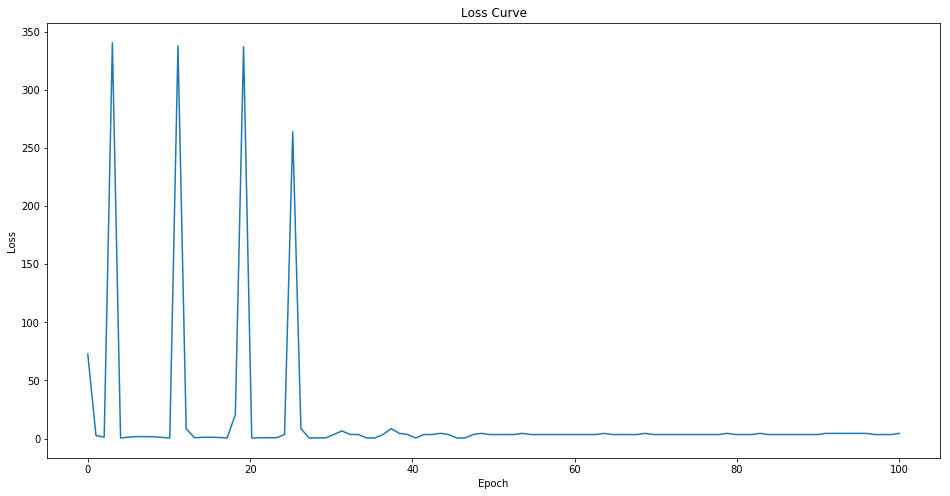

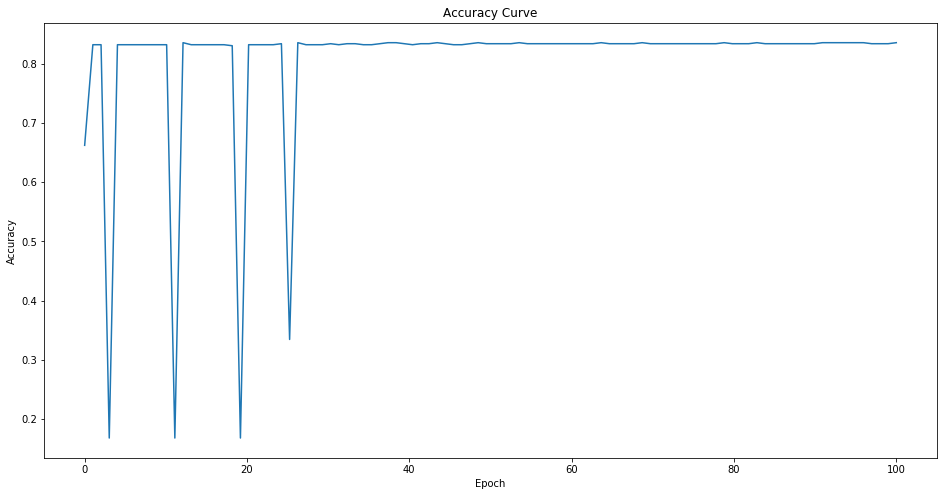

In [169]:
plot_acc_loss(losses,acc)

## Get all True/False Measurements

In [103]:
get_all_measurments(measures)

True Positive: 0.02857142857142857
True Negative: 1.0
Precision: 1.0
Negative predictive: 0.8241379310344827
false positive: 0.0
False negative: 0.9714285714285714
False discovery: 0.0
Accuracy: 0.8250428816466552


This looks like the model is very accurate, but the issue is the number of runs over 1.5 hours is much less than the number of runs below 1.5 hours. Thus the model learned to be very conservative when handing out 1's (meaning the uptime was longer than 1.5 hours), because it could do well with just assigning everything to be 0 and occasionally assign a positive value and getting it right. This could be remedied by having more data points with runtimes longer than the tolerance.

## Plot

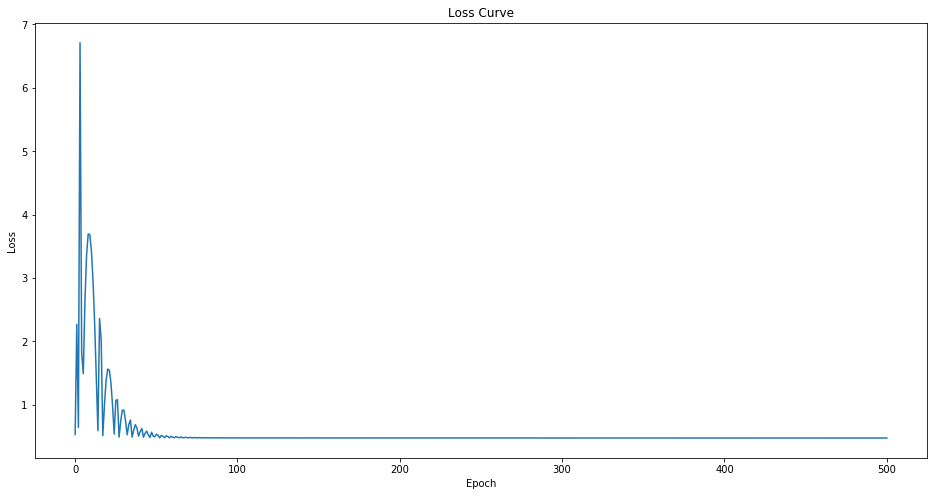

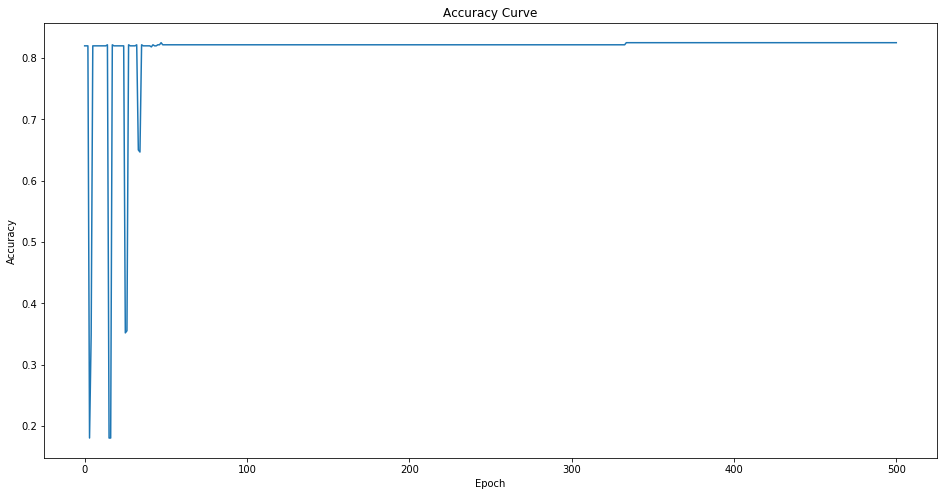

In [104]:
plot_acc_loss(losses,acc)

### Decreasing label tolerance

In [106]:
# init new model
model = Net()

# train the model with new label tolerance of 1 hours of uptime
trained_model, losses, acc, predicted, measures = train_model(model,label_tol=1, epochs=epochs)

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [107]:
get_all_measurments(measures)

True Positive: 0.024630541871921183
True Negative: 1.0
Precision: 1.0
Negative predictive: 0.657439446366782
false positive: 0.0
False negative: 0.9753694581280788
False discovery: 0.0
Accuracy: 0.660377358490566


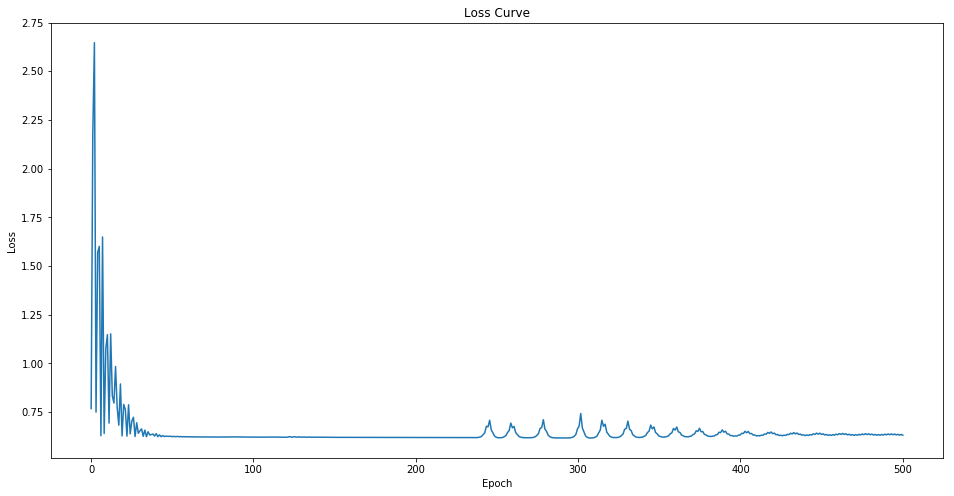

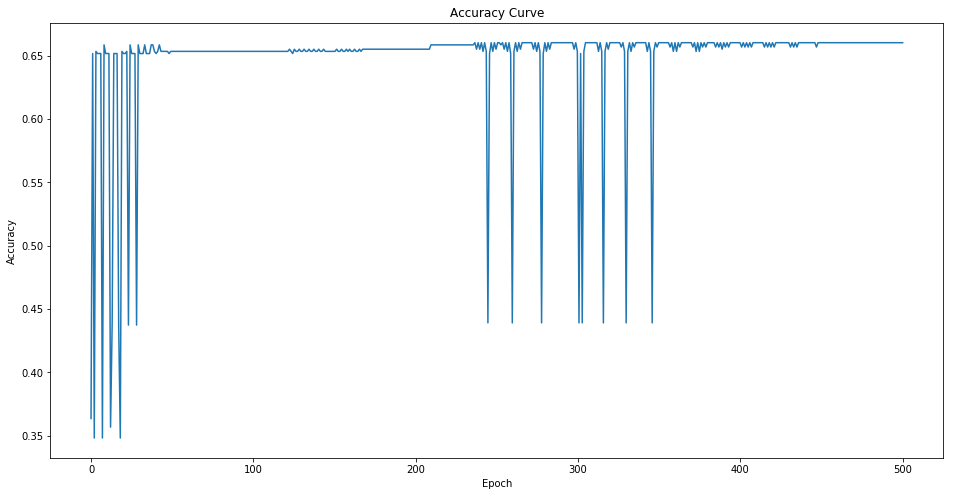

In [108]:
plot_acc_loss(losses,acc)